# Image processing project : "Describe my photo module"

##### The idea of this project is to generate a paragraph describing a photo using a combination of image processing and deep learning algorithm. This module may be useful in many domains. In medical domains, it may help scanning doctors to provide more accurate descriptions about their scans. In search engines, generating a paragraph describing the image makes the search process more robust rather than relying only on the uploader caption.

 - We'll use a pre-trained model which is ResNet-50. First of all we download it along with weights that have been trained with ImageNet. ImageNet is a very large dataset used for image classification and it contains millions of URLs, each linking to an image categorized from one of 1000 categories. (Find the dictionnary attached with the notebook)

In [106]:
from keras.applications.resnet50 import ResNet50

# define ResNet50 model
ResNet50_model = ResNet50(weights='imagenet')
print('1')

1


#### As we use TensorFlow as backend, Keras CNNs needs 4D array as input (number of samples , rows , columns , number of channels). 
Input_to_tensor takes the path of a photo and return a suitable form to supply Keras CNN. It loads the image and resize it to a squared image 244 x 244 pixels.  

In [107]:
from keras.preprocessing import image                  
from tqdm import tqdm
img_width, img_height = 224, 224

def input_to_tensor(img_path):
    # loads RGB image as PIL.Image.Image type
    img = image.load_img(img_path, target_size=(224, 224))
    # convert PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    x = image.img_to_array(img)
    # convert 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    return np.expand_dims(x, axis=0)

- Here we made a function that predict labels (from the 1000 categories in ImageNet dictionnary). Images still require some additional pre-processing, RGB is converted to BGR by re-ordering the channels. All pre-trained models have the additional normalization step that the mean pixel must be subtracted from every pixel in each image. All these procedures can be done by using the imported function preprocess_input.

In [108]:
from glob import glob
import numpy as np
from keras.applications.resnet50 import preprocess_input, decode_predictions


def ResNet50_predict(img_path):
    # returns prediction vector for image located at img_path
    img = preprocess_input(input_to_tensor(img_path))
    return np.argmax(ResNet50_model.predict(img))

- As ResNet50_predict function returns a prediction in form of number, we implemented search_in_dict() function to return a specific noun refering to the input label.

In [110]:
import re
def search_in_dict(rakam):
    file =open('dic/imagenet1000_clsidx_to_labels.txt', 'r')
    List = file.readlines()
    x=List[rakam].split("'")
    y=x[1].split(",")
    return y[0]

# test function
search_in_dict(ResNet50_predict('scene1.jpg'))

'African elephant'

####  And now it's the turn of our specific scene image. To describe a scene, we have to detect every single object, extract it and then feed all objects to Keras CNN. 
- To detect object we used contouring functions found in OpenCV 
- Every detected contour is marked in a rectangle which used later on to save the detected areas in seperate images. The pathes of these images are stored in pathes list.

Stored 'pathes' (list)
['cnt401.jpg', 'cnt411.jpg', 'cnt588.jpg', 'cnt720.jpg', 'cnt996.jpg', 'cnt1182.jpg', 'cnt1277.jpg', 'cnt1459.jpg', 'cnt1587.jpg', 'cnt1632.jpg', 'cnt1749.jpg', 'cnt2160.jpg']


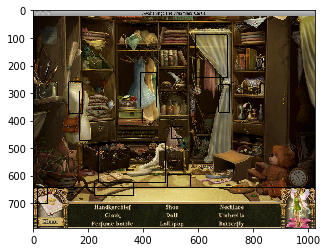

In [113]:
import numpy as np
import cv2
from matplotlib import pyplot as plt


THIN_THRESHOLD = 40

im = cv2.imread('scene10.jpg')
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

#ret, thresh = cv2.threshold(im, 127, 255, 0)
imgray = cv2.cvtColor(im,cv2.COLOR_BGR2GRAY)
ret,thresh = cv2.threshold(imgray,127,255,0)
contours,image = cv2.findContours(thresh,cv2.RETR_TREE,cv2.CHAIN_APPROX_SIMPLE)

idx = 0
pathes=[]
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    roi = im[y:y + h, x:x + w]
    if h < THIN_THRESHOLD or w < THIN_THRESHOLD:
        continue
    cv2.imwrite('cnt'+str(idx) + '.jpg', roi)
    pathes.append('cnt'+str(idx) + '.jpg')
    #cv2.rectangle(im, (x, y), (x + w, y + h), (0, 0, 0), 2)
    #ResNet50_predict_labels('cnt'+str(idx) + '.jpg')
for cnt in contours:
    idx += 1
    x, y, w, h = cv2.boundingRect(cnt)
    roi = im[y:y + h, x:x + w]
    if h < THIN_THRESHOLD or w < THIN_THRESHOLD:
        continue
   
    
    cv2.rectangle(im, (x, y), (x + w, y + h), (0, 0, 0), 2)
    #ResNet50_predict_labels('cnt'+str(idx) + '.jpg')
    
%store pathes
print(pathes)
plt.imshow(im)

- Here the pathes list is fed to the prediction function and returns a list containing the names of predicted items.

In [111]:
%store -r pathes
p=[]
for x in pathes:
    p.append(search_in_dict(ResNet50_predict(x)))
    
p

['common newt',
 'barn',
 'ladle',
 'toilet seat',
 'colobus',
 'ladle',
 'tiger shark',
 'killer whale',
 'ladle',
 'paper towel',
 'chambered nautilus',
 'four-poster']

- To avoid repititions and to give a more general solution, we eliminate all repeated elements and then we make all words plural. 

In [101]:
# Eliminate repititions
mylist = list(dict.fromkeys(p))
print(mylist)

PluralList=[]
for word in mylist:
    word = word+'s'
    PluralList.append(word)
PluralList
    

['common newt', 'barn', 'ladle', 'toilet seat', 'colobus', 'tiger shark', 'killer whale', 'paper towel', 'chambered nautilus', 'four-poster']


['common newts',
 'barns',
 'ladles',
 'toilet seats',
 'colobuss',
 'tiger sharks',
 'killer whales',
 'paper towels',
 'chambered nautiluss',
 'four-posters']

#### Finally we generate our paragraph. 
- Using random, a word is chosen randomly from different words categories (linking words, subjects, verbs, ...etc).
- A sentence is constructed for every predicted item in the prediction list (PluralList here.)

In [102]:
# generate text paragraph
import random

LinkingWords = ['At the begining', 'First of all', 'Then', 'So', 'And','','','']
Subjets = ['You', 'We', 'They', 'The user', 'The observer','You','You','You']
Verbs = ['can notice', 'may see','Would find' , 'can remark']
Adjectives = ['some', 'alot of' ,'many', 'good amount of', 'several', 'different kinds of']
words = PluralList
sentence = 'Hello to "Describe my photo module". Thank you dear user for using this module. After inspecting your photo we concluded the following.'
i=0
j=0
for eachword in words:
    sentence=sentence+ (LinkingWords[i]+' '+random.choice(Subjets)+' '+random.choice(Verbs)+' '+random.choice(Adjectives)+' '+words[j]+'.')
    if i>=len(LinkingWords)-1:
        i=2
    else:
        i=i+1
    j=j+1
sentence
#random.choice(LinkingWords)



'Hello to "Describe my photo module". Thank you dear user for using this module. After inspecting your photo we concluded the following.At the begining You may see several common newts.First of all We can remark some barns.Then You can notice alot of ladles.So The user Would find several toilet seats.And You Would find alot of colobuss. They can notice some tiger sharks. We can remark many killer whales. You can remark good amount of paper towels.Then You Would find several chambered nautiluss.So The observer can notice several four-posters.'

## Some recommended alternatives :


#### While implementing the project, some alternatives for some tasks were found. They're useful too but we choosed the optimum solutions based on our point of view.  

1- Use OpenCV haarcascade instead of keras CNN. 
   - Disadvantage : Some parameters need to be tuned differently for every single photo.

Number of faces detected: 3


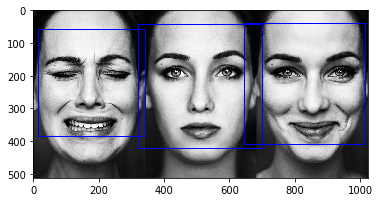

In [114]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_frontalface_alt.xml')

# load color (BGR) image
img = cv2.imread('sadhappy.jpg')
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
faces = face_cascade.detectMultiScale(gray)

# print number of faces detected in the image
print('Number of faces detected:', len(faces))

# get bounding box for each detected face
for (x,y,w,h) in faces:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

Number of smiles detected: 1


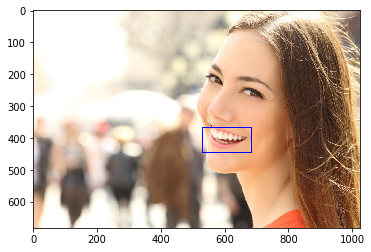

In [115]:
import cv2                
import matplotlib.pyplot as plt                        
%matplotlib inline                               

# extract pre-trained face detector
face_cascade = cv2.CascadeClassifier('haarcascades/haarcascade_smile.xml')

# load color (BGR) image
img = cv2.imread('smile2.jpg')
# convert BGR image to grayscale
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

# find faces in image
smiles = face_cascade.detectMultiScale(gray,scaleFactor=1.3,minNeighbors=25,minSize=(25, 25))

# print number of faces detected in the image
print('Number of smiles detected:', len(smiles))

# get bounding box for each detected face
for (x,y,w,h) in smiles:
    # add bounding box to color image
    cv2.rectangle(img,(x,y),(x+w,y+h),(255,0,0),2)
    
# convert BGR image to RGB for plotting
cv_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# display the image, along with bounding box
plt.imshow(cv_rgb)
plt.show()

2- Use Image Slicer instead of contouring. 
   - Disadvantage : in low detailled images, the overall shape may be lost using slicing

In [5]:
# Step 1 : Split image
import image_slicer as image_slicer
m=[]
m=image_slicer.slice('scene1.jpg',8)
m
# put addresses of splitted images in one array
k=[]
for name in m :
    l=str(name).split("- ")
    p=l[1].split(">")
    k.append(p[0])
k
# check sliced photos in project folder

['scene1_01_01.png',
 'scene1_01_02.png',
 'scene1_01_03.png',
 'scene1_02_01.png',
 'scene1_02_02.png',
 'scene1_02_03.png',
 'scene1_03_01.png',
 'scene1_03_02.png',
 'scene1_03_03.png']